# Yet Another ProPublica COMPAS notebook

## Dependencias, leer datos y preprocesar



In [11]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

#!pip install fairlearn 

df = pd.read_csv('https://raw.githubusercontent.com/javism/seminariofate2023/main/data/propublica_recidivism_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/javism/seminariofate2023/main/data/propublica_recidivism_test.csv')


In [30]:
# Mejora estética de los gráficos
import seaborn
import matplotlib as mpl
#tema matplotlib por defecto
#sty = 'default'
sty = 'seaborn-v0_8'
mpl.style.use(sty)
mpl.rcParams["figure.dpi"] = 200
seaborn.set_context("talk")  # or "paper" or "poster"; default: "notebook"

In [38]:
df

,sex,age,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,decile_score,score_text,y,race_label
0,0,39,0,1,2,2,1,19,0,141,9,2,1,black
1,0,21,2,1,0,0,0,0,0,65,9,2,1,black
2,0,24,2,1,0,0,3,0,0,257,3,0,1,black
3,1,20,2,1,0,0,3,2,0,436,10,2,1,black
4,0,53,1,1,0,0,0,2,0,176,1,0,0,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052,0,29,0,1,0,1,0,16,0,318,10,2,0,black
4053,0,31,0,1,0,0,0,7,0,277,7,1,1,black
4054,0,32,0,1,2,0,0,26,0,318,10,2,1,black
4055,1,56,1,1,0,0,0,2,1,429,1,0,1,black


Dibujamos el histograma de las puntuaciones por "raza"

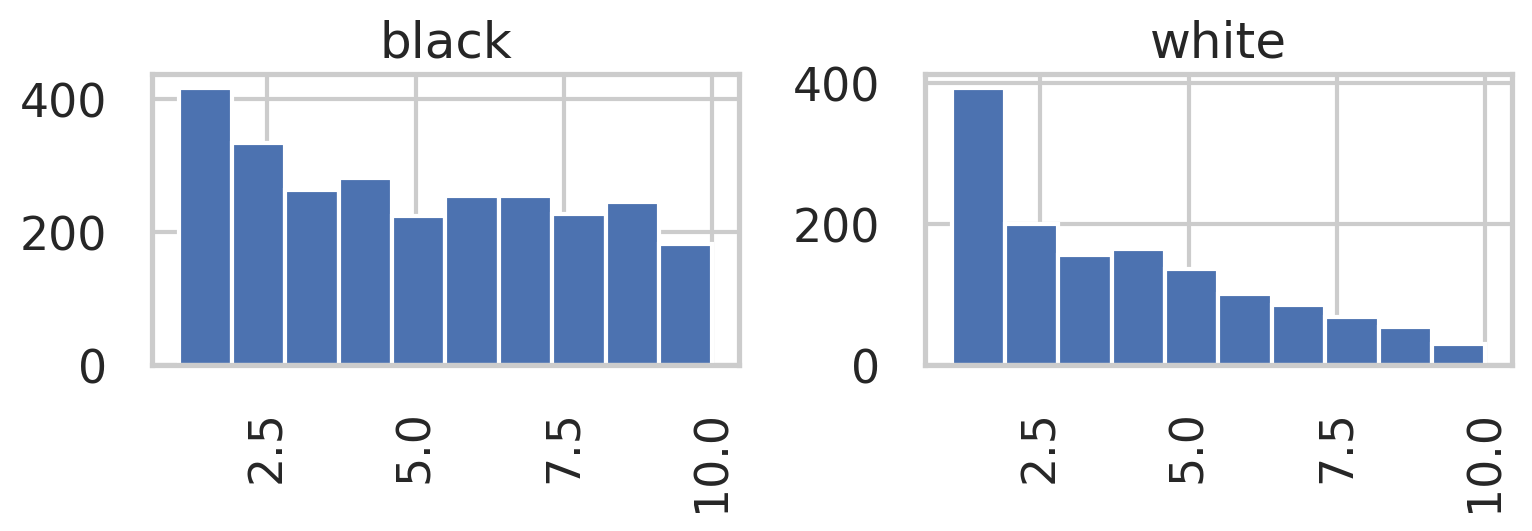

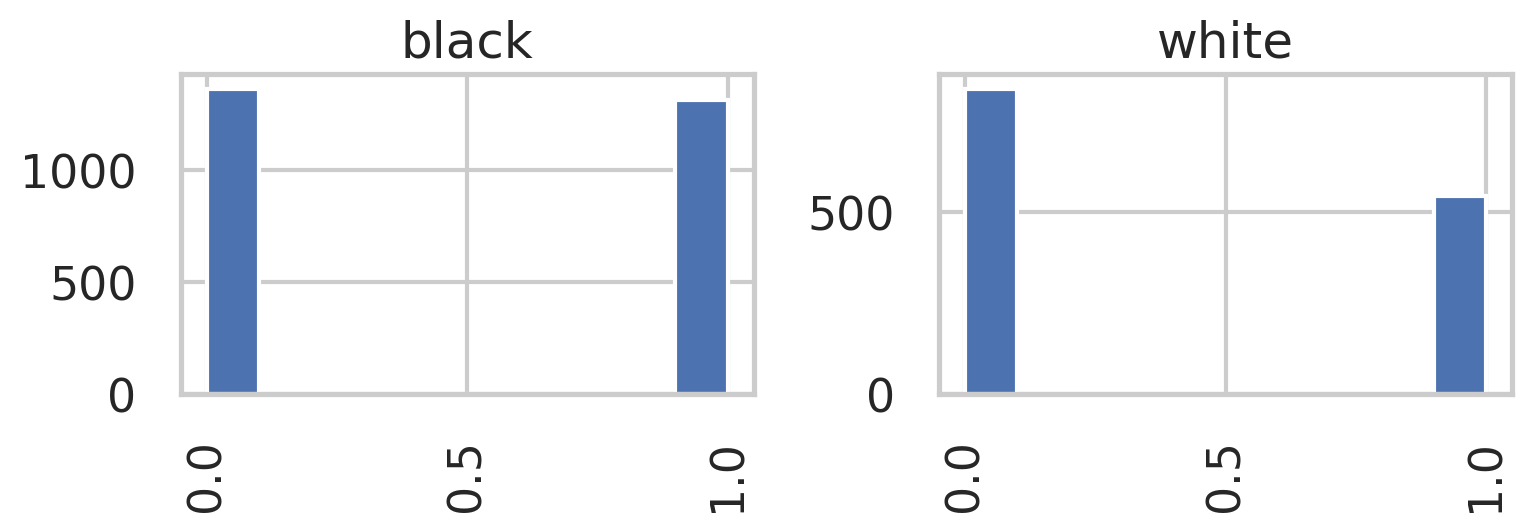

In [39]:
df['race_label'] = 'black'
df.loc[df['race'] == 0, 'race_label'] = 'white'
df_test['race_label'] = 'black'
df_test.loc[df_test['race'] == 0, 'race_label'] = 'white'

df['decile_score'].hist(by=df['race_label'], figsize = (8,3))
plt.tight_layout()
df['y'].hist(by=df['race_label'], figsize = (8,3))
plt.tight_layout()

### Comparación de variables por grupos

In [33]:
def z_score_standardization(series):
    return (series - series.mean()) / series.std()

df_s = df.copy()
for col in df_s.columns:
    if col != 'race_label':
        df_s[col] = z_score_standardization(df_s[col])
    

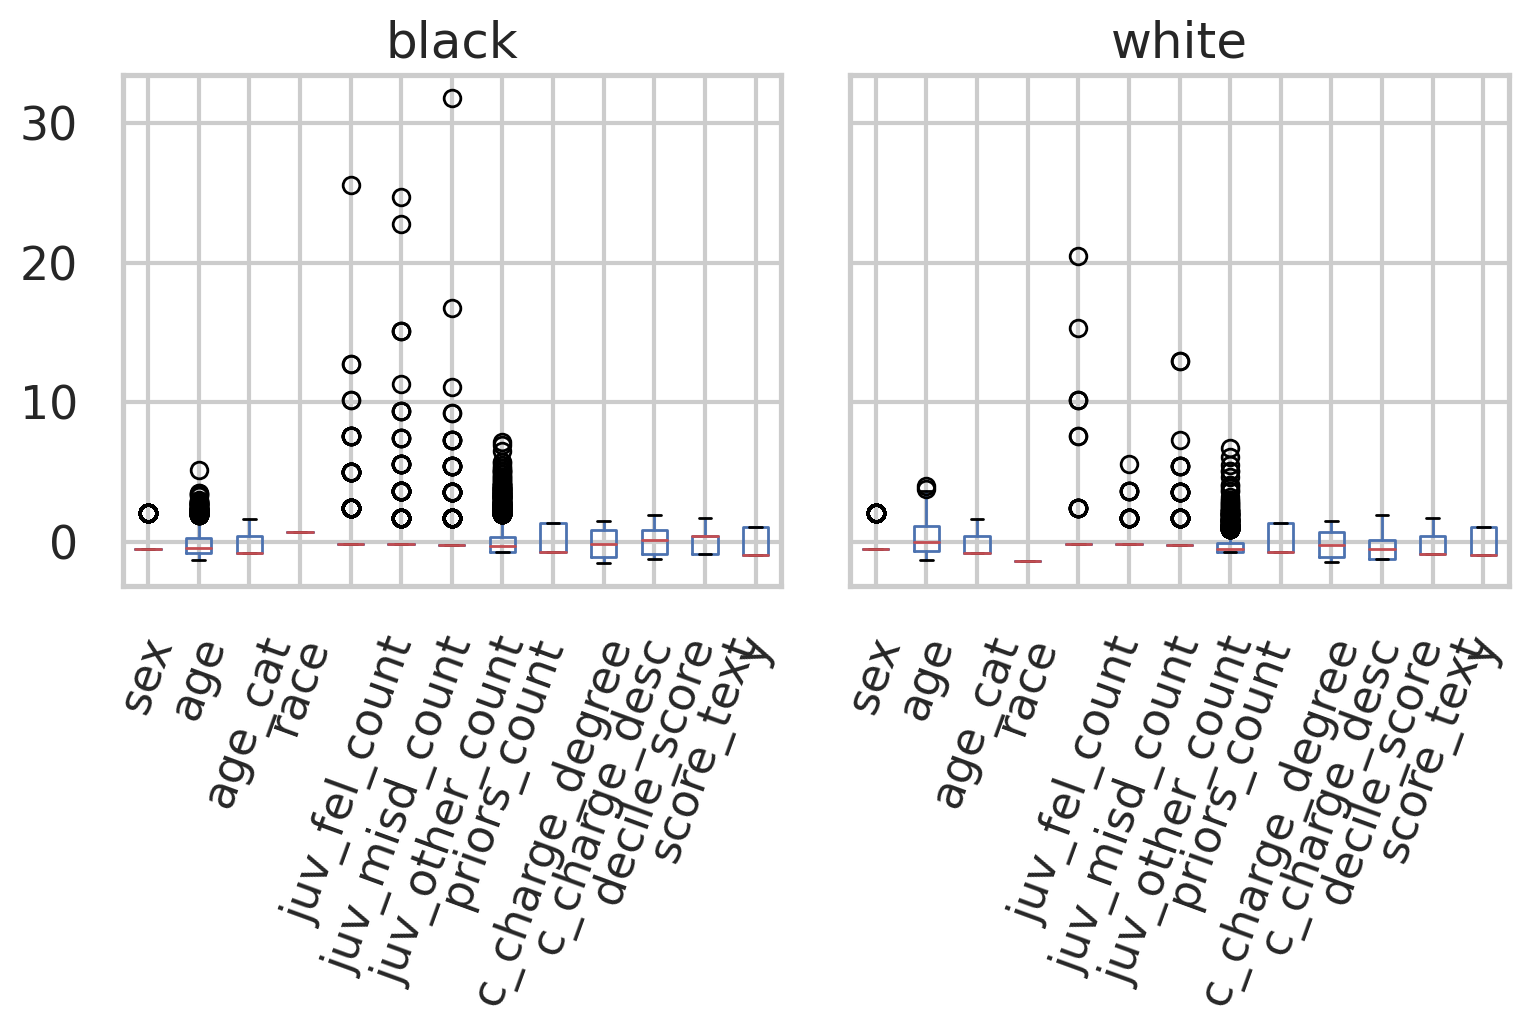

In [40]:
# Analizamos con variables estandarizadas   
df_s.groupby('race_label').boxplot(rot=70)
plt.tight_layout()

## Preprocesado


In [42]:
# Remove some variables, standarize and binarize label
race_label = df['race_label']
race_label_t = df_test['race_label']
df.drop(['c_charge_desc','decile_score','score_text', 'race_label'], axis=1, inplace=True)
df_test.drop(['c_charge_desc','decile_score','score_text', 'race_label'], axis=1, inplace=True)

X = df.drop(['y'], axis=1)
feature_names = X.columns
y = df['y']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
X_test = df_test.drop(['y'], axis=1)
y_test = df_test['y']
X_test = scaler.transform(X_test)

## Funciones auxiliares de métricas de disparidad

In [43]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from fairlearn.metrics import false_positive_rate
from fairlearn.metrics import false_negative_rate
from fairlearn.metrics import true_positive_rate
from fairlearn.metrics import selection_rate
from fairlearn.metrics import count

def performance_metrics(y_test, predictions, race_label_t): 
    # Test for discrimination in predictions
    from fairlearn.metrics import MetricFrame,false_negative_rate,false_positive_rate
    from sklearn.metrics import accuracy_score

    grouped_metric = MetricFrame(metrics=accuracy_score,y_true=y_test,y_pred=predictions, sensitive_features=race_label_t)
    print(f"Overall Accuracy = \t{grouped_metric.overall:.4f}")
    print("Accuracy by groups:")
    for key, value in grouped_metric.by_group.to_dict().items():
        print(f"Acc {key}: \t\t{value:.4f}")

    grouped_metric = MetricFrame(metrics=false_negative_rate,y_true=y_test,y_pred=predictions, sensitive_features=race_label_t)
    print(f"Overall FNR = \t\t{grouped_metric.overall:.4f}")
    print("FNR by groups: ")
    for key, value in grouped_metric.by_group.to_dict().items():
        print(f"FNR {key}: \t\t{value:.4f}")

    grouped_metric = MetricFrame(metrics=false_positive_rate,y_true=y_test,y_pred=predictions, sensitive_features=race_label_t)
    print(f"Overall FPR = \t\t{grouped_metric.overall:.4f}")
    print("FPR by groups: ")
    for key, value in grouped_metric.by_group.to_dict().items():
        print(f"\x1B[1mFPR {key}: \t\t{value:.4f}")
        

def performance_plots(y_test, predictions, race_label_t): 
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'false positive rate': false_positive_rate,
        'false negative rate': false_negative_rate,
        'count': count}
    metric_frame = MetricFrame(metrics=metrics,
                               y_true=y_test,
                               y_pred=predictions,
                               sensitive_features=race_label_t)
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        title="LR",
    )
    plt.show()


## Ajustar modelo básico y evaluar

In [44]:
# Fit a logistic regression predictor
lr = LogisticRegression()
lr.fit(X,y)

from sklearn.metrics import confusion_matrix
lr.score(X_test, y_test)
predictions = lr.predict(X_test)

performance_metrics(y_test, predictions, race_label_t)

Overall Accuracy = 	0.6685
Accuracy by groups:
Acc black: 		0.6608
Acc white: 		0.6836
Overall FNR = 		0.4277
FNR by groups: 
FNR black: 		0.3741
FNR white: 		0.5560
Overall FPR = 		0.2569
FPR by groups: 
FPR black: 		0.3088
FPR white: 		0.1693


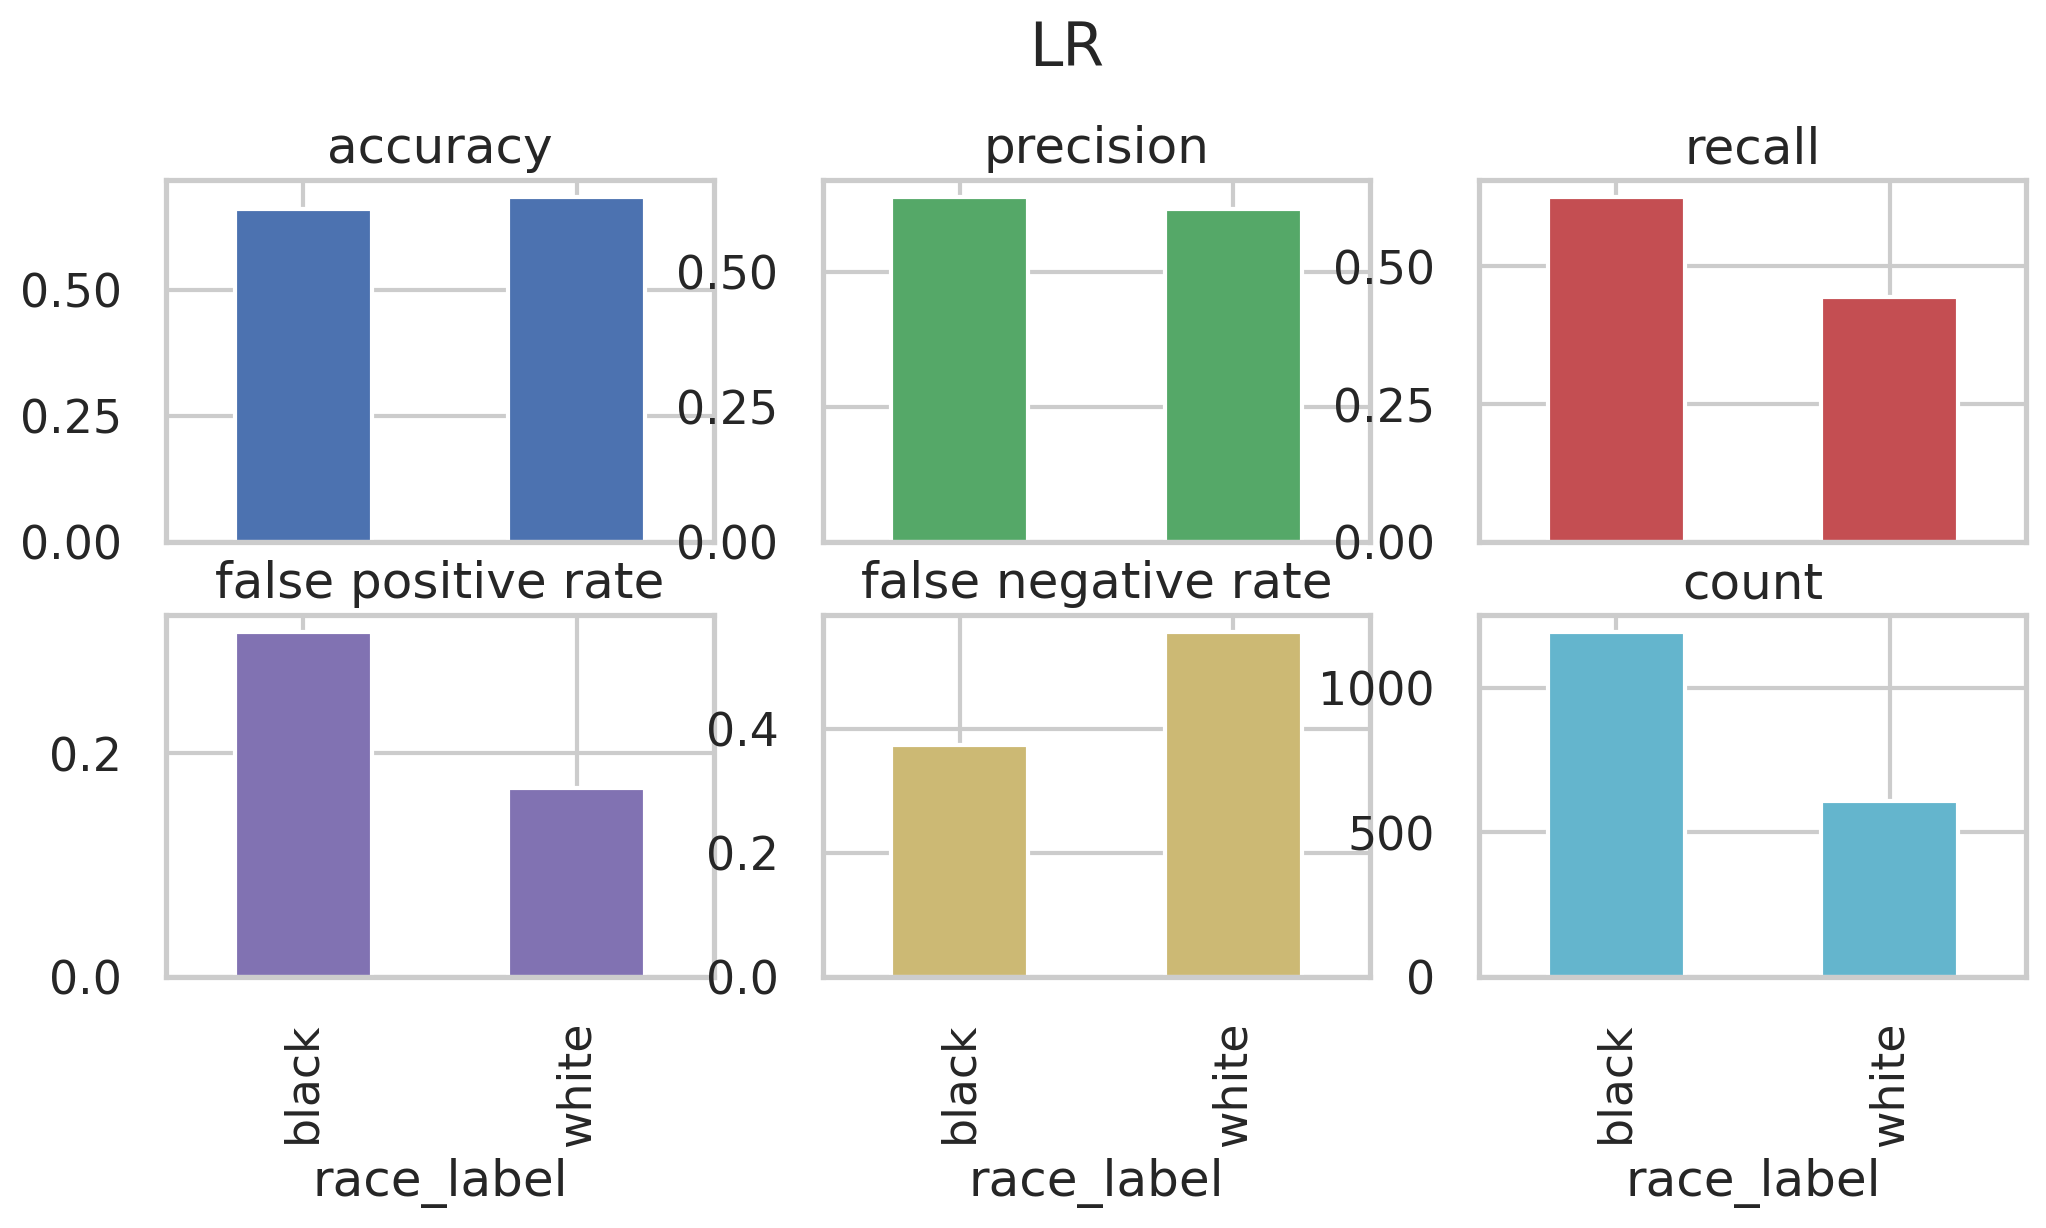

In [45]:
performance_plots(y_test, predictions, race_label_t)


## Imprimimos nuestro modelo matemático

<img src="pics/compas_diagram_pre.png" alt="COMPAS model as a graph" class="bg-primary" width="500px">

In [47]:
intercept = lr.intercept_[0];
print(f'{intercept:.3f} ', end="")
for c, f in zip(lr.coef_.ravel(), list(feature_names) ):
    print(f'{c:.3f} * {f}', end=' + ')

-0.166 -0.094 * sex + -0.532 * age + 0.142 * age_cat + 0.004 * race + 0.080 * juv_fel_count + 0.028 * juv_misd_count + 0.068 * juv_other_count + 0.796 * priors_count + -0.056 * c_charge_degree + 

# Selección de características

In [48]:
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel
print(X.shape)

lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X = model.transform(X)
X_test = model.transform(X_test)
print(X.shape)
print(X_test.shape)

print(f"Features selected by SelectFromModel: {feature_names[model.get_support()]}")

(4057, 9)
(4057, 2)
(1804, 2)
Features selected by SelectFromModel: Index(['age', 'priors_count'], dtype='object')


## Reentrenamos el modelo con el filtrado de características

Overall Accuracy = 	0.6741
Accuracy by groups:
Acc black: 		0.6717
Acc white: 		0.6787
Overall FNR = 		0.4708
FNR by groups: 
FNR black: 		0.4155
FNR white: 		0.6034
Overall FPR = 		0.2136
FPR by groups: 
FPR black: 		0.2524
FPR white: 		0.1481


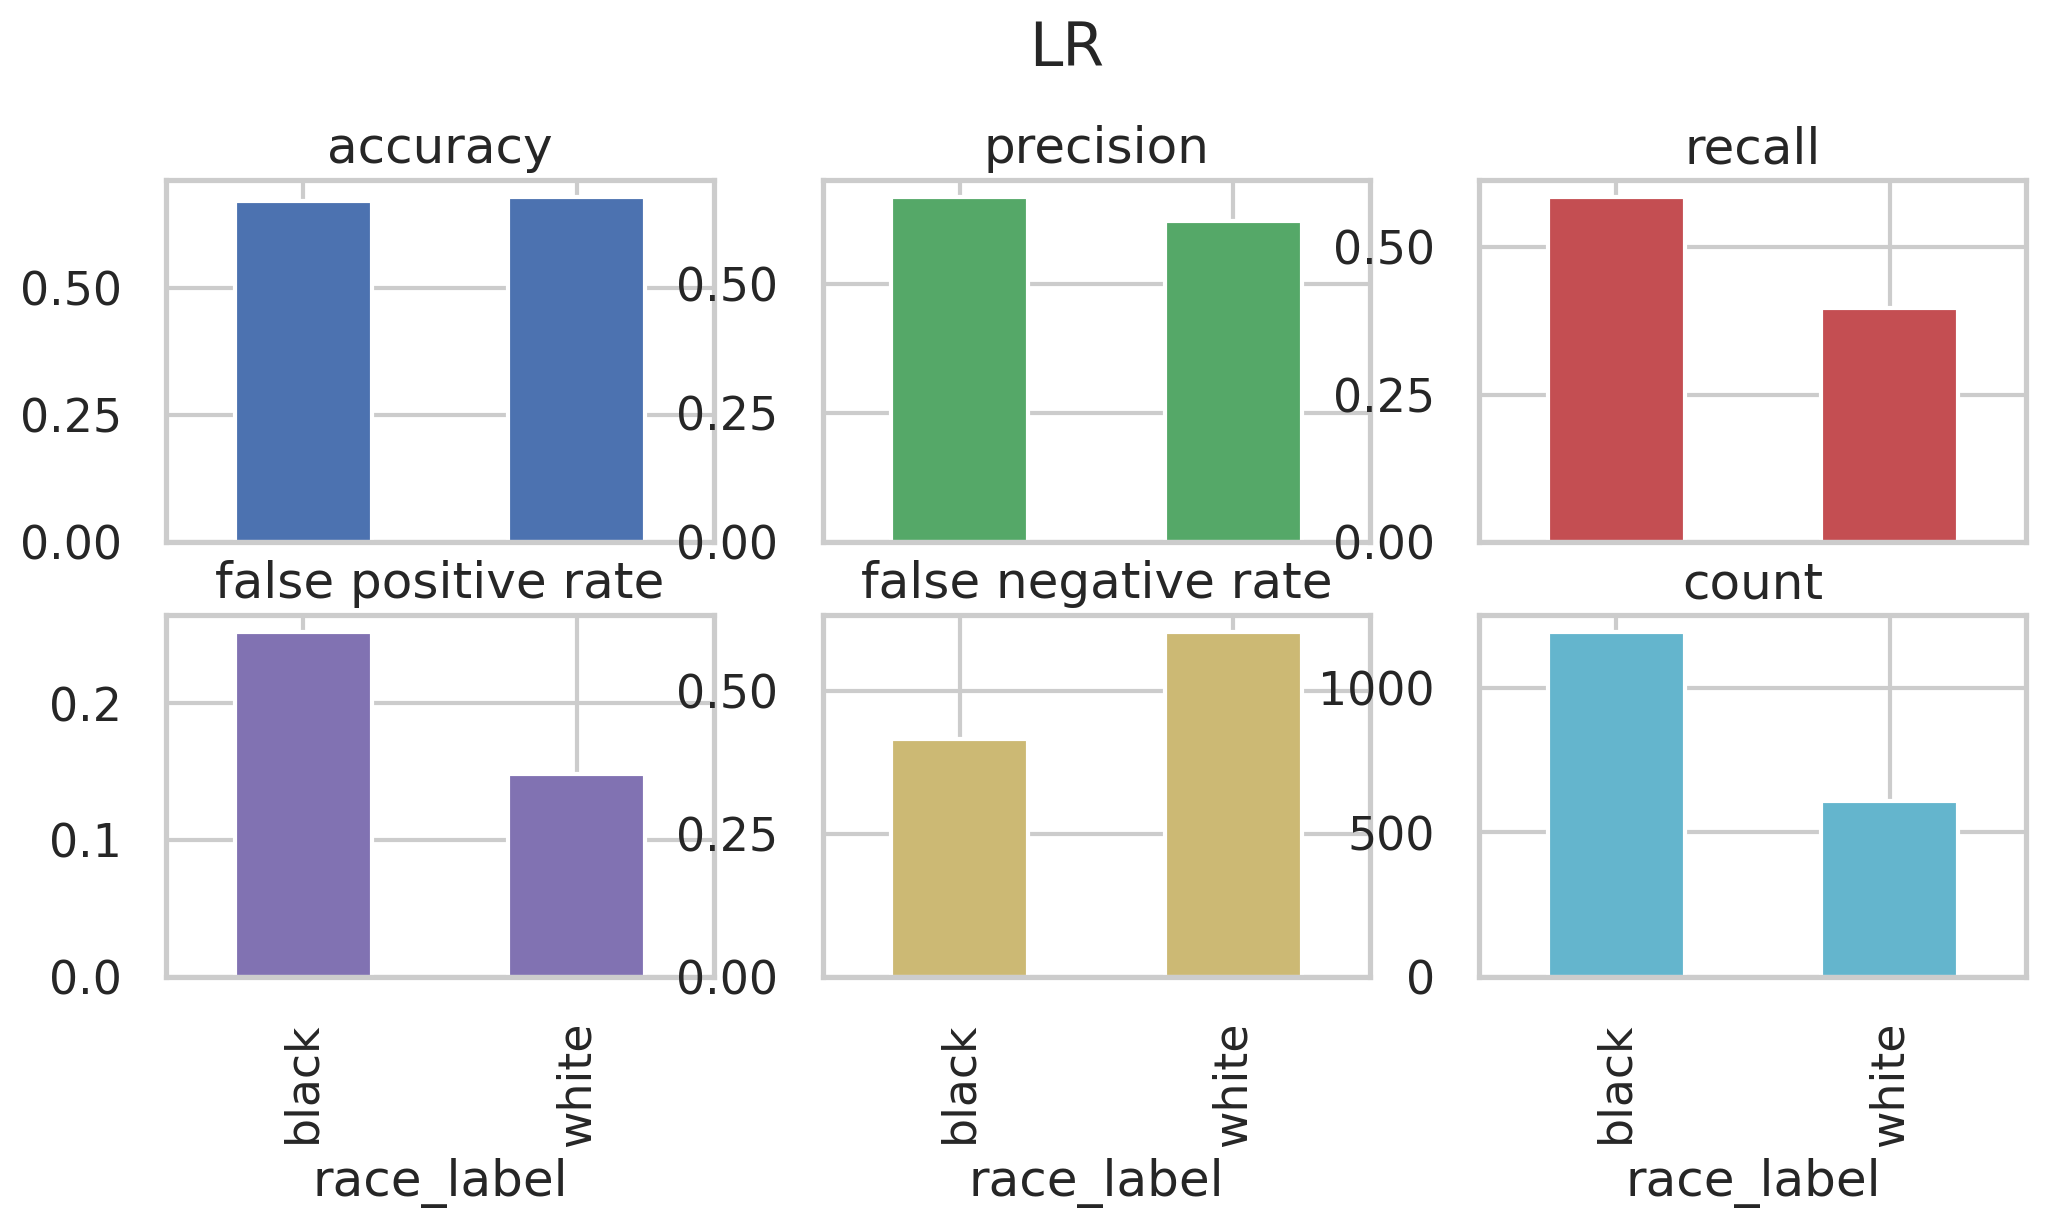

In [49]:
# Fit a logistic regression predictor
lr = LogisticRegression()
lr.fit(X,y)

from sklearn.metrics import confusion_matrix
lr.score(X_test, y_test)
predictions = lr.predict(X_test)

performance_metrics(y_test, predictions, race_label_t)
performance_plots(y_test, predictions, race_label_t)

## Imprimimos nuestro modelo matemático

In [50]:
intercept = lr.intercept_[0];
print(f'{intercept:.3f} ', end="")
for c, f in zip(lr.coef_.ravel(), list(feature_names[model.get_support()]) ):
    print(f'{c:.3f} * {f}', end=' + ')

-0.172 -0.592 * age + 0.823 * priors_count + 

## Modelo final

Esta fórmula matemática equivale al modelo de la empresa NorthPointe que a partir de 137 variables dice predecir si una persona reincidirá. 

<img src="pics/compas_diagram.png" alt="COMPAS model as a graph" class="bg-primary" width="500px">

# Conclusiones
* Cualquier modelo construído sobre los datos históricos va a reproducir desigualdades estructurales.
* Incluso reduciendo las variables al mínimo estas están mediadas (término de inferencia causal) por la "raza".
* ¿Comprarías una herramienta inteligente que predice comportamiento a partir de 137 variables?¿Y si tiene 2 variables?
* Hay otras cuestiones más importantes de fondo sobre qué entendemos por justicia y la imposibilidad de implementarla algorítmicamente si consideramos que cualquier herramienta de IA no incorpora el contexto a sus decisiones. 